In [1]:
import unittest
import numpy as np
import biom
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import medfilt
from scipy.special import softmax
from skbio.stats.composition import closure
from numpy.random import poisson, lognormal, normal, randint
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation

%matplotlib inline

In [7]:
def softmax_inv(x):
    return np.log(x)

class TestSoftInv(unittest.TestCase):

    def setUp(self):
        self.exp = closure(np.array([[100, 5, 20],
                                     [200, 234, 14]]))
        pass

    def testinv(self):

        res = softmax(softmax_inv(self.exp))
        res *= 1 / res.sum(axis=1)[0]
        try:
            np.testing.assert_array_almost_equal(res, self.exp, 6)
        except AssertionError:
            print('arrays not equal')

def simulate(X, depth=100, read_std=10.0,
             pnormal=0.1, pheter=0.1,
             pzero=0.1, mwindow=False):
    """
    Poisson Log-Normal simulation
    on real count data. The proceedure
    follows the same steps as
    Äijö et al. [1] but with a Poisson
    Log-Normal count model. This allows
    the total read depth to vary across
    samples which can be modeled by the
    dispersion perameter of the Poisson.

    Parameters
    ----------
    table : array like
        A matrix of counts.
    depth : int
        Mean read depth of the
        simulation.
    read_std : float
        Controls dispersion.
    pnormal : float [0,1]
        Percent
        normally-distributed
        noise to the data.
    pheter : float [0,1]
        Percent random
        noise to the data.
    pzero : float [0,1]
        Percent zeros added.

    Returns
    -------
    sim : array-like
        simulated counts.

    References
    ----------
    .. [1] Äijö, Tarmo, Christian L. Müller,
           and Richard Bonneau. 2018.
           “Temporal Probabilistic Modeling of Bacterial
           Compositions Derived from 16S rRNA Sequencing.”
           Bioinformatics  34 (3): 372–80.
    """

    # subset and order single digester
    print("Starting simulation...")
    sim = X.copy()
    # (1) estimate proportions
    sim = closure(sim)
    print("Step 1 done")
    # (2) filter low-mean reads
    abund_filt_mask = sim.mean(axis=0) > 1e-5
    mask_index = [i for i, v in enumerate(abund_filt_mask) if v]
    sim = sim.T[abund_filt_mask].T
    print("Step 2 done")
    # (3) median filter by feature
    if mwindow:
        for i in range(sim.shape[1]):
            sim[:, i] = medfilt(sim[:, i], mwindow)
    sim = closure(sim)  # check closure
    print("Step 3 done")
    # (4) project onto real space
    # with inverse softmax
    sim = softmax_inv(sim)
    print("Step 4 done")
    # (5) noise gauss (@10% of samps.)
    err = pnormal * np.ones_like(sim)
    sim = normal(sim, err)
    # add some random noise (@10% of samps.)
    err = pheter * np.ones_like(sim)
    i = randint(0, err.shape[0], 5000)
    j = randint(0, err.shape[1], 5000)
    err[i, j] = 0.5
    sim = normal(sim, err)
    # add random zeros (@10% of samps.)
    err = pzero * np.ones_like(sim)
    i = randint(0, err.shape[0], 100)
    j = randint(0, err.shape[1], 100)
    err[i, j] = 0.0
    sim = normal(sim, err)
    print("Step 5 done")
    # (6) back to prop
    sim = closure(softmax(sim))
    print("Step 6 done")
    # (7) Poisson - Log-Normal Counts
    mean = depth
    stdev = read_std
    phi = (stdev ** 2 + mean ** 2) ** 0.5
    mu = mean**2 / phi
    mu = np.log(mu * sim.T)
    sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
    sim = np.vstack([poisson(lognormal(mu[:, i],
                                       sigma))
                     for i in range(sim.shape[0])])
    print("Step 7 done")
    return sim, mask_index, sigma

In [3]:
#read in data and metadata
data_path = './data/'
# import table(s)
table = biom.load_table('{}seeding_study_table.biom'.format(data_path))
# import metadata
metadata = pd.read_csv('{}seeding_study_metadata.tsv'.format(data_path), sep='\t')
metadata.index = metadata['#SampleID']
metadata.drop('#SampleID', axis=1, inplace=True)
metadata.head()

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_18136/184293839.py:6: DtypeWarning: Columns (2,52,72) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('{}seeding_study_metadata.tsv'.format(data_path), sep='\t')


,qiita_study,prep_name,run_name,100nt_deblur,sequencing_id,baby_birth_date,baby_sex,birth_mode,birth_mode_ms,body_site_corrected,...,sex,state,study_id,subjectid,subjectid_unique,taxon_id,title,tube_id,village,well
#SampleID,,,,,,,,,,,,,,,,,,,,,
1718.1.14.I01.DM.200P,1718.0,3627,Knight infant timeseries,56612.0,Sample_Knight16S_KnightBaby_25512,11/4/11,F,CSseed,CSseed,Feces,...,NaN,CO,1718.0,CO.1,CO.1,NaN,NaN,NaN,Boulder,NaN
1718.11.26.I01.RP,1718.0,3627,Knight infant timeseries,56612.0,Sample_Knight16S_KnightBaby_25512,11/4/11,F,CSseed,CSseed,Right_Hand,...,NaN,CO,1718.0,CO.1,CO.1,NaN,NaN,NaN,Boulder,NaN
1718.BLANK24,1718.0,3627,Knight infant timeseries,56612.0,Sample_Knight16S_KnightBaby_25512,11/4/11,F,CSseed,CSseed,Control,...,NaN,CO,1718.0,CO.1,CO.1,NaN,NaN,NaN,Boulder,NaN
1718.12.17.I01.TONG,1718.0,3627,Knight infant timeseries,56612.0,Sample_Knight16S_KnightBaby_25512,11/4/11,F,CSseed,CSseed,Mouth,...,NaN,CO,1718.0,CO.1,CO.1,NaN,NaN,NaN,Boulder,NaN
1718.11.27.I01.RP,1718.0,3627,Knight infant timeseries,56612.0,Sample_Knight16S_KnightBaby_25512,11/4/11,F,CSseed,CSseed,Right_Hand,...,NaN,CO,1718.0,CO.1,CO.1,NaN,NaN,NaN,Boulder,NaN


In [4]:
table.to_dataframe()

,1718.1.14.I01.DM.200P,1718.11.26.I01.RP,1718.BLANK24,1718.12.17.I01.TONG,1718.11.27.I01.RP,1718.11.18.I01.FH,1718.2.9.I01.VAG,1718.11.19.I01.DM.440A,1718.11.11.mum01.TONG,1718.11.19.I01.FH,...,10894.MGDB.ESP.JUL18.0875,10894.MGDB.ESP.JUL18.0273,10894.MGDB.ESP.JUL18.BL27,10894.MGDB.ESP.JUL18.0423,10894.MGDB.ESP.JUL18.0919,10894.MGDB.ESP.JUL18.0746,10894.MGDB.ESP.JUL18.1401,10894.MGDB.ESP.JUL18.0382,10894.MGDB.ESP.JUL18.0665,10894.MGDB.ESP.JUL18.1058
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,14842.0,4.0,5715.0,6.0,8.0,2.0,10.0,70.0,5.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0
TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCG,11535.0,174.0,9107.0,38.0,966.0,495.0,9.0,23857.0,7.0,1283.0,...,4716.0,4.0,4099.0,0.0,3.0,75.0,254.0,0.0,0.0,0.0
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGACAGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,9857.0,0.0,3102.0,4.0,0.0,84.0,1.0,119.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGT,8626.0,0.0,1353.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGCCCATCGCTTAACGGTGGGTCTG,4656.0,0.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGTAGGTCCCGAGCGTTGTCCGGATTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTCGTCGCGTCTGGTGCGAAAGCCCATCGCTTAACGGTGGGTTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TACGTAGGGTGCAAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGCGAAAGCCCACGGCTCAACCGTGGAGGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Real data

In [35]:
ids_to_keep = []
for id in metadata.subjectid.unique():
    #check the # of instances of each id
    id_freq = metadata[metadata.subjectid == id].shape[0]
    if (id_freq >= 10) & (id_freq <= 30):
        ids_to_keep.append(id)
len(ids_to_keep)

21

In [36]:
metadata_short = metadata[metadata.subjectid.isin(ids_to_keep)]
sample_ids = metadata_short.index.tolist()
print(len(sample_ids))
print(metadata_short.subjectid.value_counts())

492
HR.71        30
DB4CP_Mom    30
HR.65        29
32           28
HR.67        28
16M          28
NY.37        27
DB2V_Baby    27
DB2V_Mom     26
DB6V_Mom     24
NY.31        23
HR.61        23
19B          22
DB6V_Baby    22
14B          21
NY.35        20
HR.57        20
20B          19
15B          18
7B           17
16B          10
Name: subjectid, dtype: int64


In [37]:
table_df = table.to_dataframe()[sample_ids]
table_sub = biom.Table(table_df.values, table_df.index, table_df.columns)
table_sub = table_sub.subsample(n=40000, axis='observation', by_id=True)
table_sub

40000 x 489 <class 'biom.table.Table'> with 12773 nonzero entries (0% dense)

In [38]:
table_transformed = clr_transformation(table_sub.copy(), pseudocount=1)

In [39]:
table_transformed.to_dataframe().head()

,10249.C032.01SS,10249.C032.09SS,10249.C032.21SS,10249.C032.23SS,10249.C032.22SS,10249.C032.12SD,10249.M032.01R,10249.M032.01SS,10249.M032.01V,10249.C032.14SS,...,10894.MGDB.ESP.JUL18.0083,10894.MGDB.ESP.JUL18.0109,10894.MGDB.ESP.JUL18.0093,10894.MGDB.ESP.JUL18.0393,10894.MGDB.ESP.JUL18.0362,10894.MGDB.ESP.JUL18.0124,10894.MGDB.ESP.JUL18.0082,10894.MGDB.ESP.JUL18.0135,10894.MGDB.ESP.JUL18.0357,10894.MGDB.ESP.JUL18.0382
TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGCCCATCGCTTAACGGTGGGTCTG,1.789279,-0.000415,-0.002675,-0.00275,-0.002506,-0.000411,-0.003573,-0.002418,-0.001713,-0.000810,...,-0.003085,-0.000563,-0.002512,-0.000249,-0.001233,-0.000278,-0.001725,-0.002064,-0.001090,-0.001375
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,-0.002481,-0.000415,2.705376,-0.00275,-0.002506,-0.000411,-0.003573,6.412679,-0.001713,-0.000810,...,-0.003085,-0.000563,-0.002512,-0.000249,-0.001233,-0.000278,-0.001725,-0.002064,-0.001090,-0.001375
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATCAGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGG,-0.002481,-0.000415,-0.002675,-0.00275,2.300079,-0.000411,-0.003573,-0.002418,-0.001713,4.811375,...,3.888735,-0.000563,4.301553,-0.000249,-0.001233,-0.000278,-0.001725,2.705986,-0.001090,-0.001375
TACGTAAGGTCCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGTACGTAGGCGGGTAAGCAAGTTAGAAGTGAAATCCTATAGCTCAACTATAGTAAGC,-0.002481,-0.000415,-0.002675,-0.00275,-0.002506,-0.000411,2.635484,-0.002418,2.942726,-0.000810,...,-0.003085,-0.000563,-0.002512,-0.000249,-0.001233,-0.000278,-0.001725,-0.002064,-0.001090,-0.001375
TACGTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGC,-0.002481,3.090627,2.636383,-0.00275,-0.002506,1.945499,-0.003573,1.607020,-0.001713,-0.000810,...,-0.003085,-0.000563,-0.002512,-0.000249,-0.001233,1.098334,-0.001725,4.995148,5.282113,-0.001375


In [13]:
#run joint-ctf
(subject_loads, feature_loads, 
 state_loads, subject_lambdas,
 var_explained, feature_covs) = joint_ctf(tables=[table_transformed],
                                          sample_metadatas=[metadata_short],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid',
                                          state_column='date_sampling_category_days_continuous')
print(subject_lambdas)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 11 iterations
Calculate components for component_2
Reached convergence in 9 iterations
Calculate components for component_3
Reached convergence in 15 iterations
     component_1  component_2  component_3
16S   516.852648   387.863247   176.133983
               component_1  component_2  component_3
var_explained     0.512818     0.325518     0.161664


In [14]:
metadata_short.birth_mode_ms.value_counts()

Vag       374
CSseed     70
CS         48
Name: birth_mode_ms, dtype: int64

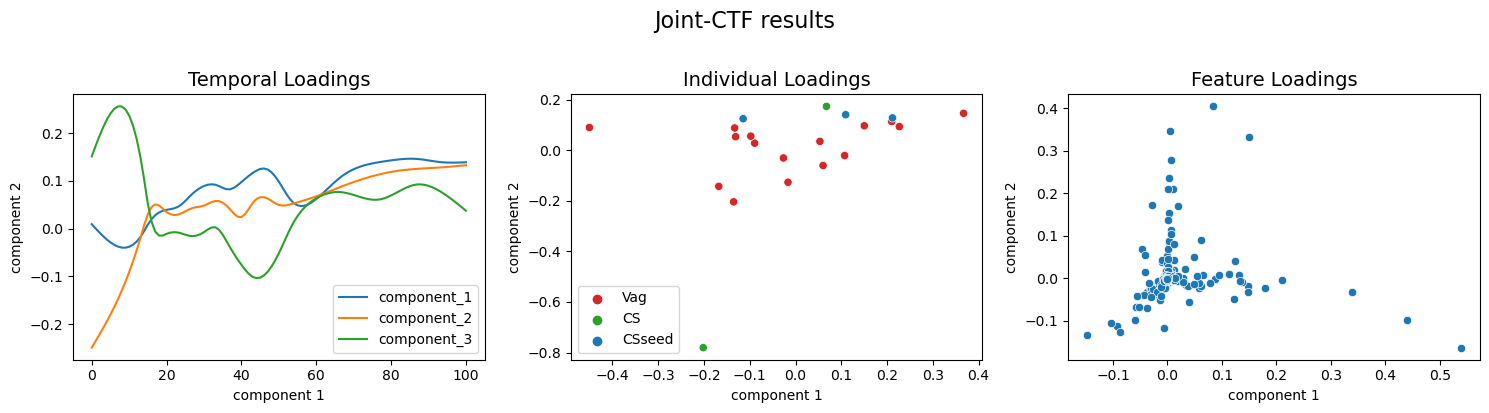

In [31]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = metadata_short.groupby('subjectid').agg({'birth_mode_ms':'first'})
group_colors = {'Vag': 'tab:red', 
                'CSseed': 'tab:blue',
                'CS': 'tab:green'}

# Plotting temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
             ax=axn[0], dashes=False)
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()

# Plotting individual loadings
sns.scatterplot(x=subject_loads['16S'][comp1], y=subject_loads['16S'][comp2],  
                ax=axn[1], hue=mf1['birth_mode_ms'], palette=group_colors)
axn[1].set_title('Individual Loadings', fontsize=14)
axn[1].legend(loc='best')

# Plotting feature loadings
sns.scatterplot(x=feature_loads['16S'][comp1], y=feature_loads['16S'][comp2], 
                ax=axn[2])
axn[2].set_title('Feature Loadings', fontsize=14)

# Adjusting titles and labels
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
for ax in axn:
    ax.set_xlabel(comp1.replace('_', ' '))
    ax.set_ylabel(comp2.replace('_', ' '))

plt.tight_layout()
plt.show()

## Simulations

In [6]:
table_df = table.matrix_data.toarray().T
print(table_df.shape)
table_df

(13516, 193216)


array([[1.4842e+04, 1.1535e+04, 9.8570e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.0000e+00, 1.7400e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.7150e+03, 9.1070e+03, 3.1020e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7900e+02, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]])

In [8]:
sim, mask_index, sigma = simulate(table_df, 
                                  depth=100, read_std=10.0,
                                  pnormal=0.1, pheter=0.1,
                                  pzero=0.1, mwindow=False)

Starting simulation...


: 